# Dollar-Cost Averaging BTC

Dollar Cost Averaging (DCA) is an investment strategy where one buys the same dollar amount of an asset over regular intervals in order to reduce short-term volatility.

## Import Libraries

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from scipy import stats
%matplotlib inline

import json
import requests
import datetime
import calendar
import random

import math
import seaborn as sns
import collections
from collections import defaultdict

## Obtain Bitcoin Price Data

In [8]:
H_URL = 'https://api.coindesk.com/v1/bpi/historical/close.json'
today = datetime.date.today().strftime("%Y-%m-%d")
# API powered by CoinDesk #


def fetch_hist_price(start_date = '2010-07-18', end_date = today):
    """Return historical price series of bitcoin in USD, 
    date entry in YYYY-MM-DD format, data starts 2010-07-18.
    """
        
    #Uses date parameters in API call
    payload = {'start': start_date, 'end': end_date}
    bpi_hist = requests.get(H_URL, params = payload).json()
    
    return bpi_hist["bpi"]

In [28]:
#Fetch bitcoin prices starting from 2010-07-18

spy_start = datetime.datetime(2010,7,18)
spy_end = datetime.date.today()

btc = fetch_hist_price()
df_btc = pd.DataFrame(list(btc.items()), columns=['Date', 'Close'])
df_btc.set_index('Date',drop=True,inplace=True)
df_btc.index = pd.to_datetime(df_btc.index)
df_btc.head()

,Close
Date,
2010-07-18,0.0858
2010-07-19,0.0808
2010-07-20,0.0747
2010-07-21,0.0792
2010-07-22,0.0505


## Visualize Data

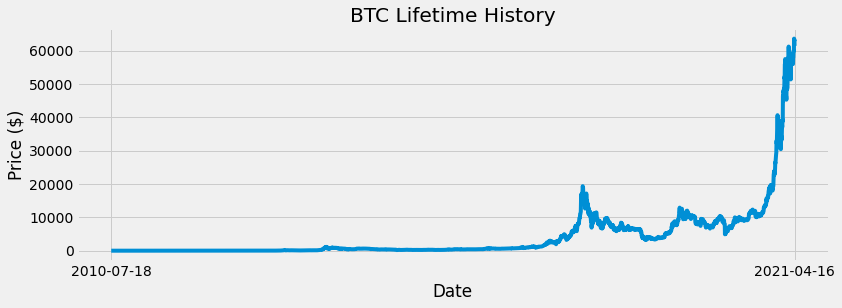

In [73]:
style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_btc.index,df_btc['Close'])

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('BTC Lifetime History')
plt.xticks([min(df_btc.index), max(df_btc.index)])
plt.show()

# #####
# ax.plot('date', 'adj_close', data=data)

# # Major ticks every 6 months.
# fmt_half_year = mdates.MonthLocator(interval=6)
# ax.xaxis.set_major_locator(fmt_half_year)

# # Minor ticks every month.
# fmt_month = mdates.MonthLocator()
# ax.xaxis.set_minor_locator(fmt_month)

# # Text in the x axis will be displayed in 'YYYY-mm' format.
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# # Round to nearest years.
# datemin = np.datetime64(data['date'][0], 'Y')
# datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlim(datemin, datemax)

# # Format the coords message box, i.e. the numbers displayed as the cursor moves
# # across the axes within the interactive GUI.
# ax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
# ax.grid(True)

# # Rotates and right aligns the x labels, and moves the bottom of the
# # axes up to make room for them.
# fig.autofmt_xdate()

In [29]:
def buy_all_now_return(buy_date):
    '''d is the date that you are buying'''
    price_0 = df_btc.loc[buy_date,'Close']
    ret = df_btc['Close'].iloc[-1] / price_0 - 1
    return ret

In [34]:
buy_all_now_return('2017-01-01')

60.53710956763271

In [31]:
PERIODS = 12
DAYS_BETWEEN = 30

In [32]:
def dollar_cost_average_return(d, periods=PERIODS, freq=str(DAYS_BETWEEN) + 'D'):
    '''spread your purchase over the next x months from date d'''
    buy_dates = pd.date_range(start=d, periods=periods, freq=freq)
    buy_dates = [i for i in buy_dates if i < df_btc.index[-1]] # remove dates in the future
    
    #avg returns for purchase dates
    return np.mean([buy_all_now_return(d) for d in buy_dates])

In [33]:
dollar_cost_average_return('2017-01-01')

31.663705863667843

In [ ]:
# SPY 12-month simulation
num_iter = 20000
stock_data = df_spy
dollars = 1000
num_months = 12
spy12_sim_dat = []

for k in range(num_iter):
    x = dollar_cost_average_return(df_btc, dollars, num_months)
    spy12_sim_dat.append(100*x)

In [36]:
color = []
diffs = []

end_date = (df_btc.index[-1] - datetime.timedelta(days=PERIODS * DAYS_BETWEEN))#.strftime('%Y-%m-%d') 
#end_date = (datetime.now() - timedelta(days=1 * DAYS_BETWEEN + 1))#.strftime('%Y-%m-%d') 

for d, row in df_btc.iterrows():
    if d < end_date:
        bn = buy_all_now_return(d)
        dca = dollar_cost_average_return(d)
        
        years = (df_btc.index[-1] - d).days / 365.25
        dca_pa = (dca + 1) ** (1/years) - 1
        bn_pa = (bn + 1) ** (1/years) - 1
        diffs.append( (dca_pa-bn_pa)*100 )
        
        if dca>bn:
            color.append('green')
        else:
            color.append('red')
    else:
        diffs.append(np.NAN)
        color.append('gray')

df_btc['color'] = color
df_btc['diffs'] = diffs

In [37]:
df_btc.index[-1] - end_date

Timedelta('360 days 00:00:00')

In [38]:
df_btc['color'].value_counts()

red      2500
green    1065
gray      361
Name: color, dtype: int64

In [40]:
days_dca_better = float(df_btc['color'].value_counts()[1]) / (len(df_btc) - PERIODS * DAYS_BETWEEN) * 100
print("Dollar cost averaging is better %0.2f%% of the time" % days_dca_better)

Dollar cost averaging is better 29.87% of the time


In [42]:
df_btc['red'] = np.where(df_btc['color'] == 'red', df_btc['Close'], np.NAN)
df_btc['gray'] = np.where(df_btc['color'] == 'gray', df_btc['Close'], np.NAN)

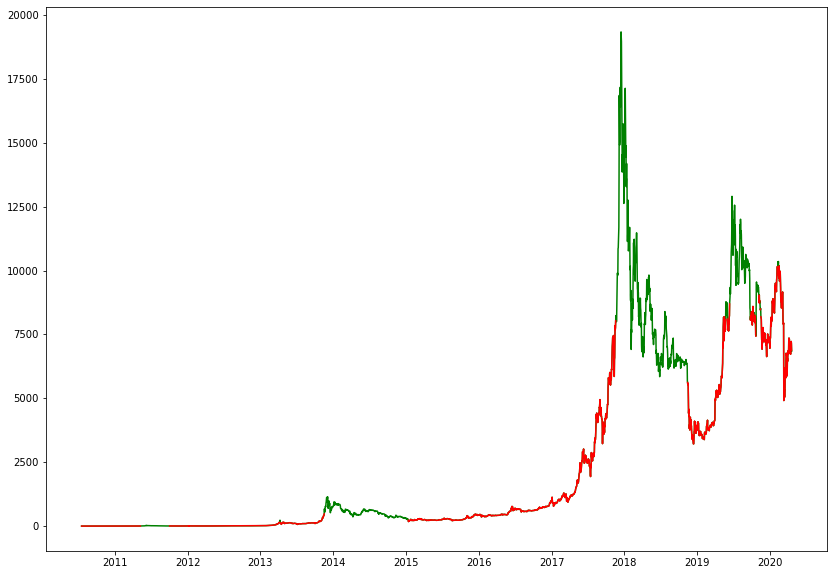

In [44]:
plt.figure(figsize=(14,10))
subset = df_btc.loc[:end_date]

plt.plot(subset['Close'].loc[:end_date], color='green')
plt.plot(subset['red'], color='red');
plt.plot(subset['gray'],color='gray', linestyle='dashed', alpha=0.2);

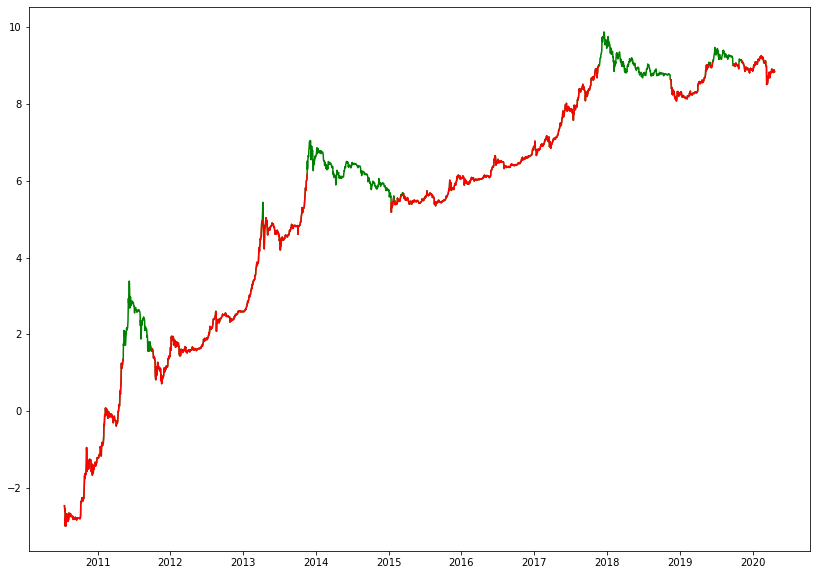

In [45]:
plt.figure(figsize=(14,10))
subset = df_btc.loc[:end_date]

plt.plot(np.log(subset['Close'].loc[:end_date]), color='green')
plt.plot(np.log(subset['red']), color='red');
plt.plot(np.log(subset['gray']),color='gray', linestyle='dashed', alpha=0.2);

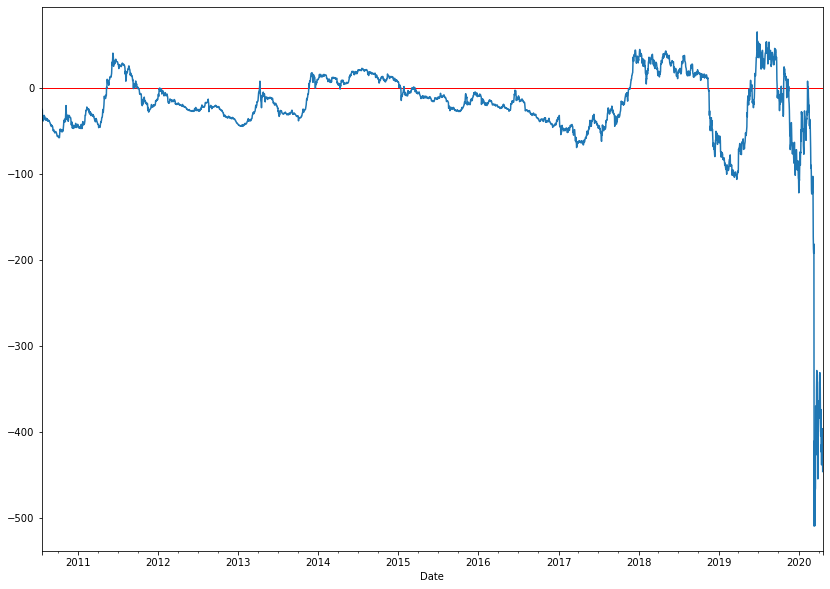

In [46]:
t = df_btc['diffs'].loc[:end_date]
t.plot(figsize=(14,10));
plt.hlines(0, t.index[0], t.index[-1], color='red', linewidth=1);
#plt.hlines(t[t>0].mean(), t.index[0], t.index[-1], color='green', linewidth=1, linestyle='dashed');
#plt.hlines(t[t<0].mean(), t.index[0], t.index[-1], color='red', linewidth=1, linestyle='dashed');

In [48]:
print (t[t>0].mean())
print (t[t<0].mean())

19.67467116783483
-37.25618470540425


In [49]:
from bokeh.plotting import figure, output_file, show

output_file("dollar_cost_averaging.html")

p = figure(plot_width=1000, plot_height=600, x_axis_type="datetime")

p.line(subset['Close'].index, subset['Close'], color="green", alpha=0.5, line_width=2)
p.line(subset['red'].index, subset['red'], color="red", alpha=0.5, line_width=2)
p.line(subset['gray'].index, subset['gray'], color="gray", alpha=1, line_width=2)

show(p)

In [ ]:
#Powered by Coindesk API
#forked from dcimring/crypto-price-analysis